# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 17th of february at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [162]:
# Change here using YOUR first and last names
fn1 = "mohamed"
ln1 = "el fakir"
fn2 = "zakaria"
ln2 = "echchair"

filename = "_".join(map(lambda s: s.strip().lower(), ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_el fakir_mohamed_and_echchair_zakaria.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [163]:
%matplotlib inline

In [164]:
pip install jupyter_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [165]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

import jupyter_black

jupyter_black.load(
    line_length=120,
    verbosity="DEBUG",
)

np.set_printoptions(precision=3)

from IPython.display import display, Markdown, Latex, HTML

import warnings

warnings.filterwarnings("ignore")
# from IPython.core.display import HTML

In [166]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {
    "axes.labelsize": fontsize + 2,
    "font.size": fontsize + 2,
    "legend.fontsize": fontsize + 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "text.usetex": usetex,
}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [167]:
print(numba.__version__)  # Your version of Numba

0.56.4


In [168]:
@njit
def go_fast(a):  # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):  # Numba likes loops
        trace += np.tanh(a[i, i])  # Numba likes NumPy functions
    return a + trace  # Numba likes NumPy broadcasting


x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x)  # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [169]:
np.tanh(0) + np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [170]:
%timeit go_fast(x)

1.93 µs ± 781 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [171]:
%timeit go_fast.py_func(x)

30.4 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [172]:
@njit
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2.0 * n) + lbda * norm(x) ** 2 / 2.0


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [173]:
@njit
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return -a_i * b_i / (1.0 + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1.0 + np.exp(-bAx))) + lbda * norm(x) ** 2 / 2.0


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4.0 * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [174]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1.0, corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [175]:
def simu_logreg(x, n, std=1.0, corr=0.5):
    """Simulation for the logistic regression problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    A, b = simu_linreg(x, n, std=1.0, corr=corr)
    return A, np.sign(b)

In [176]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1) ** idx * np.exp(-idx / 10.0)

_A, _b = simu_linreg(x_model_truth, n, std=1.0, corr=0.1)
# _A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

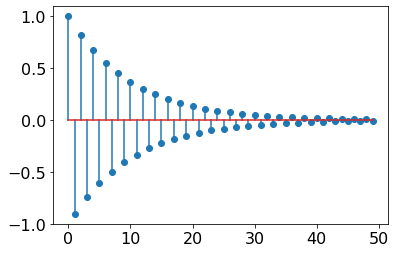

In [177]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [178]:
from scipy.optimize import check_grad

lbda = 1.0 / n **0.5

A, b = simu_linreg(x_model_truth, n, std=1.0, corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.30105426809091e-06

In [179]:
lbda = 1.0 / n **0.5

A, b = simu_logreg(x_model_truth, n, std=1.0, corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.170154964699477e-07

### Choice of the model

In [180]:
A, b = simu_linreg(x_model_truth, n, std=1.0, corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1.0 / n**0.5

### Compute the theoretical step-size for gradient descent

In [181]:
step = 1.0 / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06230377842307045


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.

In [182]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5269590118107434
1.330308651384059e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD)

### Define a class to monitor iterations

In [183]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [184]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [185]:
@njit
def gd(x_init, grad, n_iter=100, step=1.0, store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, *args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [186]:
step = 1.0 / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b, lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [187]:
@njit
def agd(x_init, grad, n_iter=100, step=1.0, args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.0
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_minus = x
        x = y - step * grad(y, *args)
        t_minus = t
        t = (1 + np.sqrt(1 + 4 * t_minus**2)) / 2
        y = x + ((t_minus - 1) / t) * (x - x_minus)

    return x, x_list

In [188]:
step = 1.0 / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b, lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [189]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    plt.tight_layout()


def plot_time(monitors, solvers, xscale="linear", yscale="log"):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)
    plt.tight_layout()

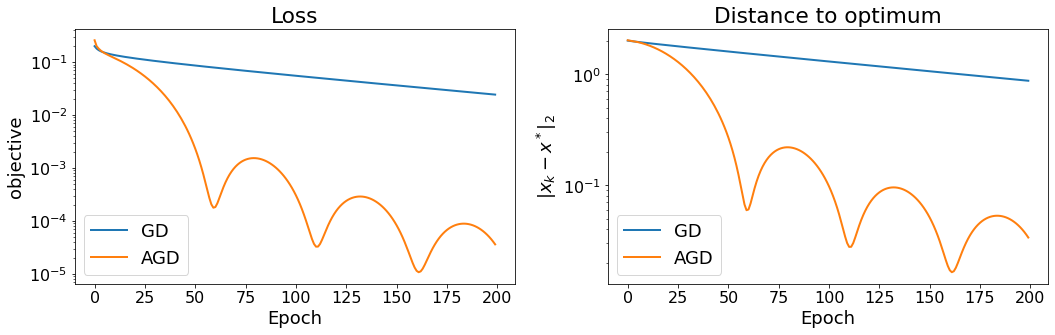

In [190]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

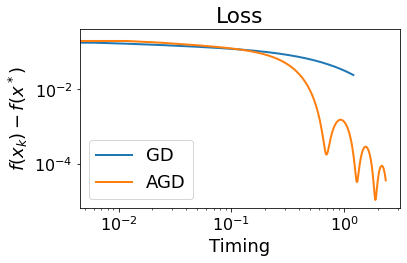

In [191]:
plot_time(monitors, solvers, xscale="log")

### compute the timing to attend a given precison of solution in order to compare it later with the SGD and ASGD solution

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?


*ANSWERS*:

- Since we use here gradient descent, so each iterations takes the whole dataset as one batch,  and compute the gradient for the whole dataset, which cost $\theta$(n). as a result the cost become extremly high for large dataset
- the convergence rate of AGD is faster than GD, and it's normal, because:

| Regime   |      Gradient descent      |  AGD |
|----------|:-------------:|------:|
| before oscillations| $\|x_{k+1} - x^*\| \leq \|x_k -x^*\|$ | $\|y_{k+1} - x^*\| \leq \|y_k -x^*\|$  |
| after oscillations| $\|x_{k+1} - x^*\| \leq \|x_k -x^*\|$ | $\|y_{k+1} - x^*\| ???  \|y_k -x^*\|$ because $y_{k+1}=x_{k+1}$ + $\alpha$ (which could push it farther than the optimum ) |

then the gradient of y comes to correct the misestimation of the $x_{k+1}$ with respect to optimum by changing its direction

<a id='stoc'></a> 
## 4. Stochastic methods

In [192]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [193]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1.0, store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]

        ### TODO
        x -= step * grad_i(i, x, *args) / np.sqrt(idx + 1)
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [194]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b, lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [195]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1.0, store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]

        ### TODO
        averaged_gradient -= gradient_memory[i, :] / n
        gradient_memory[i, :] = grad_i(i, x, *args)
        averaged_gradient += gradient_memory[i, :] / n
        x -= step * averaged_gradient
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [196]:
max_squared_sum = np.max(np.sum(A**2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)

monitor_sag = monitor(sag, loss, x_min, (A, b, lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [197]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1.0, store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):

        ### TODO
        # for t in range(n):
        if idx % n == 0:
            x_old = x.copy()
            mu_k = grad(x_old, *args)
        i = random_indices[idx]
        x = x - step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu_k)

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())

    return x, x_list

In [198]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b, lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

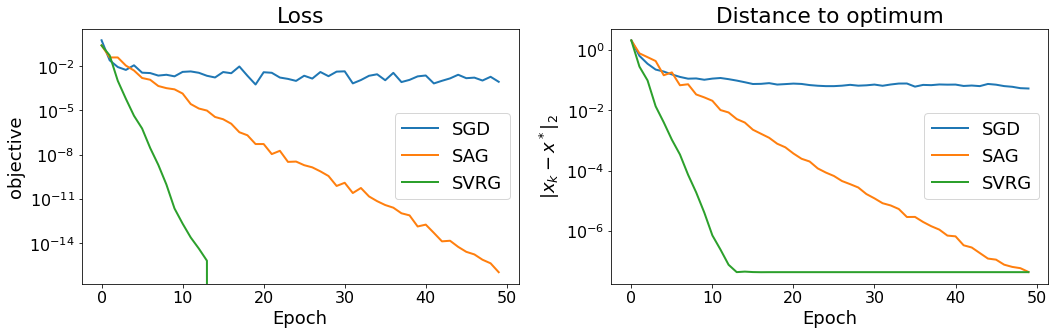

In [199]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

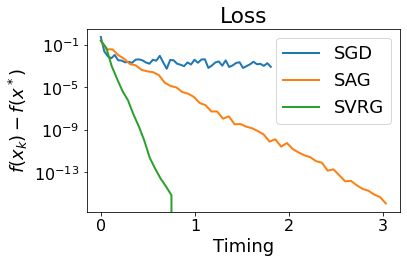

In [200]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

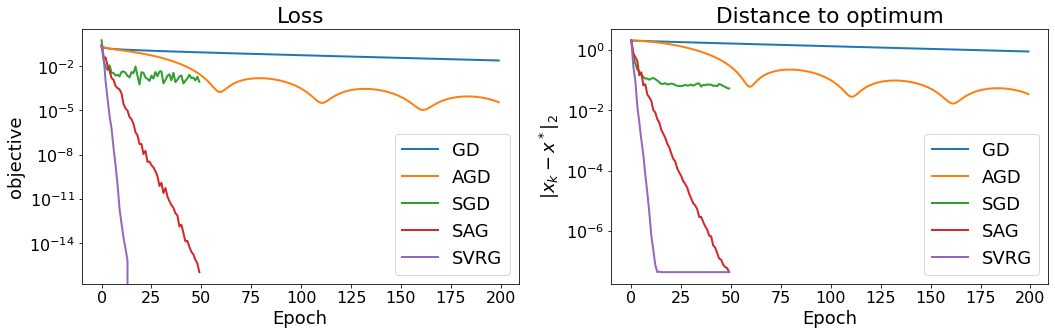

In [201]:
monitors = [monitor_gd, monitor_agd, monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

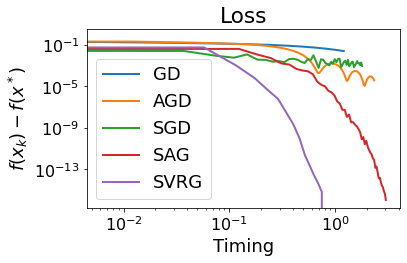

In [202]:
plot_time(monitors, solvers, xscale="log")

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

We create our compare_function_n to facilitate our task of comparing different configurations by varying lambda or correlation. Also, to plot our figure we will use the following function plot_epochs_and_time.

In [203]:
def plot_epochs_and_time(monitors, solvers,title=""):
    fig = plt.figure(figsize=(20, 4))
    st = fig.suptitle(title,y=1.1,fontsize="medium")
    ax1 = fig.add_subplot(1, 3, 1)
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("$f(x_k) - f(x^*)$")
    ax1.legend(solvers,prop={'size': 10})
    plt.tight_layout()

    ax2 = fig.add_subplot(1, 3, 2)
    for monit in monitors:
        ax2.semilogy(monit.err, lw=2)
        ax2.set_title("Distance to optimum")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("$\|x_k - x^*\|_2$")
    ax2.legend(solvers,prop={'size': 10})
    plt.tight_layout()
  
    ax3 = fig.add_subplot(1, 3, 3)
    for monit in monitors:
        objs = monit.obj
        ax3.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        ax3.set_xscale('log')
        ax3.set_title("Loss")
        ax3.set_xlabel("Timing")
        ax3.set_ylabel("$f(x_k) - f(x^*)$")
    ax3.legend(solvers,prop={'size': 10})
    plt.tight_layout()

In [204]:
def compare_function_n( lbda,x_model_truth=x_model_truth, n = 10000, model= 'regression', std=1., corr=0.5, plot='epoch_and_time'):
    
    # For linear regression
    if model == 'regression':
      A, b = simu_linreg(x_model_truth, n, std= std, corr=corr)
      loss = loss_linreg
      grad = grad_linreg
      grad_i = grad_i_linreg
      lipschitz_constant = lipschitz_linreg
      title = f'Linear regression, with $\lambda$ = {lbda} and corr = {corr}'


    # For logistic regression
    else :
      A, b = simu_logreg(x_model_truth, n, std=std, corr=corr)
      loss = loss_logreg
      grad = grad_logreg
      grad_i = grad_i_logreg
      lipschitz_constant = lipschitz_logreg
      title = f'Logistic regression, with $\lambda$ = {lbda} and corr = {corr}'

    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

    # gd
    x_init = np.zeros(d)
    n_iter = 200
    step = 1.0 / lipschitz_constant(A, b, lbda)
    monitor_gd = monitor(gd, loss, x_min, (A, b, lbda))
    monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    # agd
    x_init = np.zeros(d)
    step = 1.0 / lipschitz_constant(A, b, lbda)
    monitor_agd = monitor(agd, loss, x_min, (A, b, lbda))
    monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    #
    n_iter = 50

    # generate indices of random samples
    random_indices = np.random.randint(0, n, n * n_iter)

    # sgd
    x_init = np.zeros(d)
    step0 = 1e-1
    monitor_sgd = monitor(sgd, loss, x_min, (A, b, lbda))
    monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

    # sag
    x_init = np.zeros(d)
    max_squared_sum = np.max(np.sum(A**2, axis=1))
    step = 1.0 / (max_squared_sum + lbda)
    monitor_sag = monitor(sag, loss, x_min, (A, b, lbda))
    monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

    # svrg
    x_init = np.zeros(d)
    monitor_svrg = monitor(svrg, loss, x_min, (A, b, lbda))
    monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

    #create our list

    monitors = [monitor_gd, monitor_agd, monitor_sgd, monitor_sag, monitor_svrg]

    solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]
    if plot == 'epoch':
      plot_epochs(monitors, solvers)
    elif plot == 'time':
      plot_time(monitors, solvers, xscale="log")
    elif plot == 'epoch_and_time':
      plot_epochs_and_time(monitors, solvers,title)

***QUESTIONS :***
- Compare and comment your results

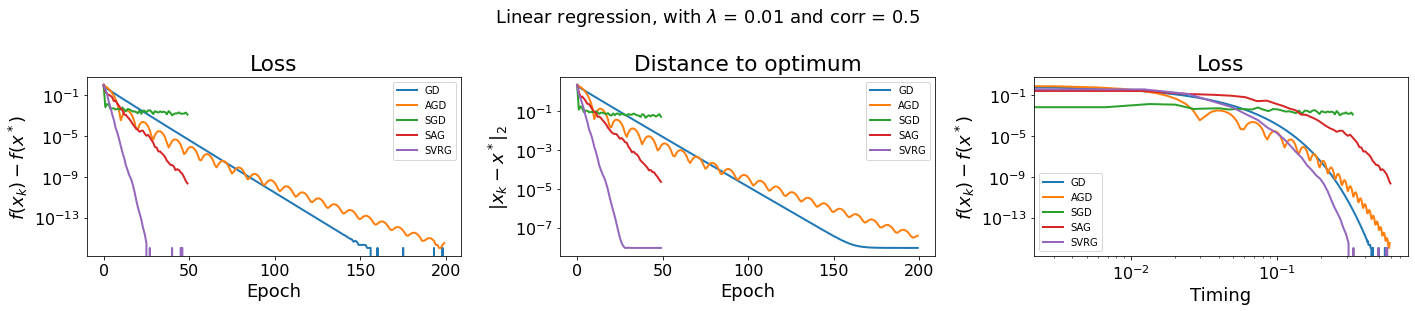

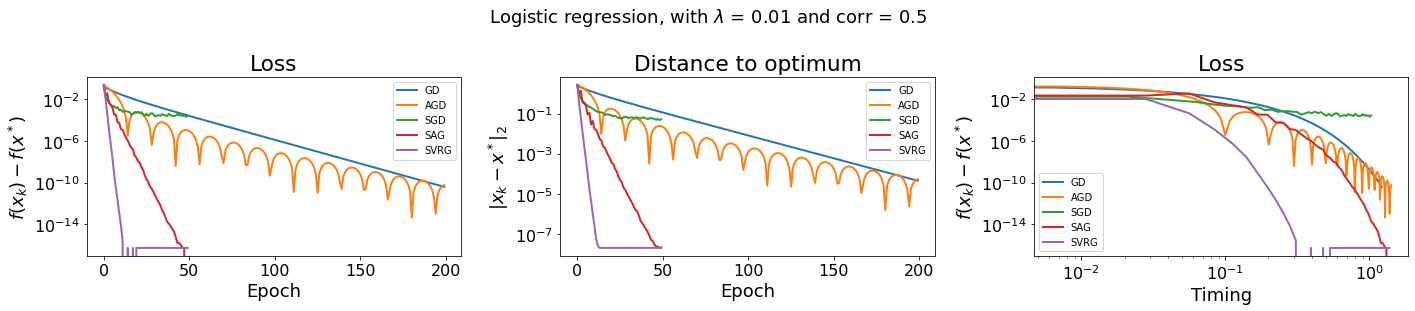

In [205]:
lbda = 1/n**0.5
compare_function_n( lbda = lbda, model= 'regression', corr=0.5)
compare_function_n( lbda = lbda, model= 'logistic', corr=0.5)

***Comment :***

**Stochastic gradient methods** perform better than deterministic methods in general, in particular for the SAG (only for logistic regression) and SRVG methods. This is due to the fact that stochastic methods update the gradient in a stochastic way which helps to converge faster because the most gradient are directed to a decent direction. SAG perform much less on the linear regression compared to logistic regression.

**Deterministic gradient methods** are in fact more stable than the stochastic methods, and perform very well on the linear regression as SVRG approximately. Nonetheless, regarding the stochastic methods, the SRVG method is definitely more stable than the two others. Moreover, the stochastic methods are more stable for Logistic Regression than for Linear Regression. 

SGD in the same perspective of stochastic methods is fast but have low distance to optimum compared with other solvers wether deterministic ones and stochastics ones.

<a id='conc'></a>

***QUESTIONS :***
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.

Low ridge regularization $\lambda = 1/n$ :

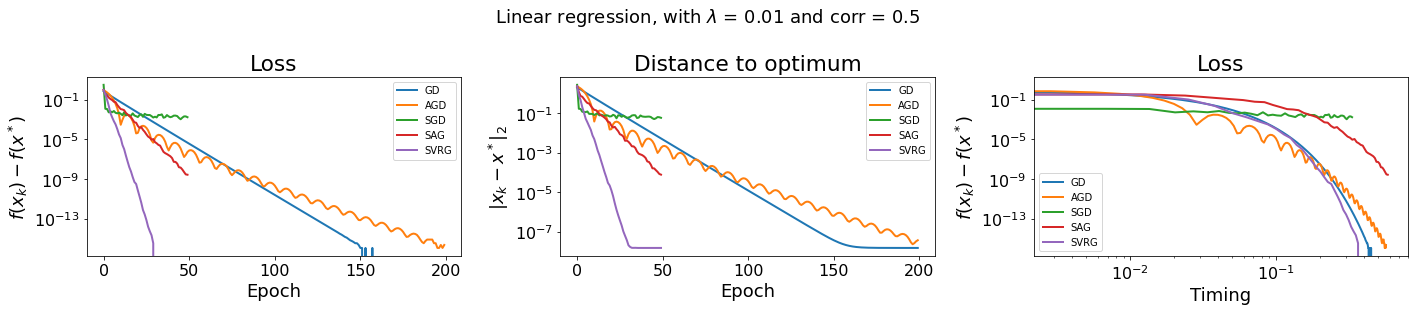

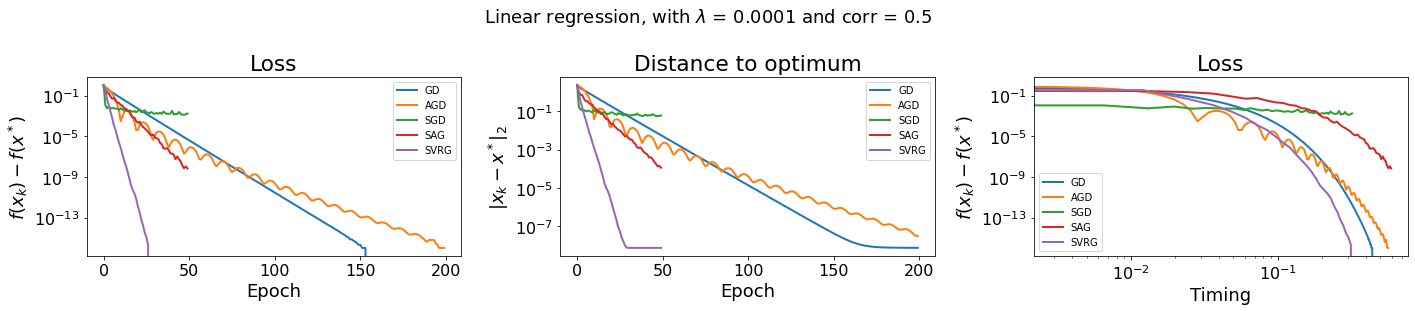

In [206]:
lbda = 1/n**0.5
new_lbda = 1/n
compare_function_n( lbda = lbda, model= 'regression', corr=0.5)
compare_function_n( lbda = new_lbda, model= 'regression', corr=0.5)

***Comment :***

We observe that for linear regression the main difference when we choose a smaller $\lambda$ that the speed of convergence increased slightly for SVRG and SAG, however SGD isn't affected with the change of lambda. On another hand, we see that the AGD method get slightly slower when $λ$ get smaller, however GD stays the same and perform quietly as SVRG in terms of time and distance to optimum. Also, SAG still slower and perform badly than all solvers except the SGD which is less accurate.

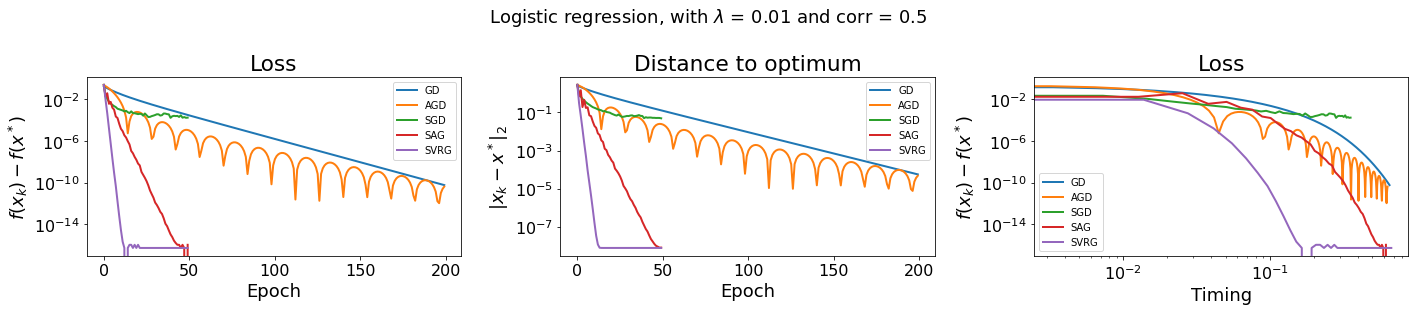

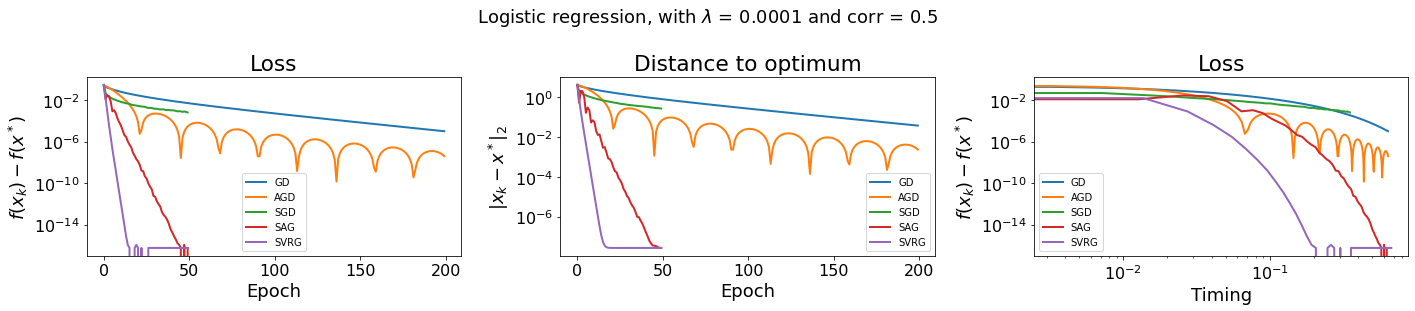

In [207]:
lbda = 1/n**0.5
new_lbda = 1/n
compare_function_n( lbda = lbda, model= 'logistic', corr=0.5)
compare_function_n( lbda = new_lbda, model= 'logistic', corr=0.5)

***Comment :***

We observe that for logistic regression the main difference when we choose a smaller $\lambda$ that the speed of convergence decreased slightly for SVRG and SAG, however SGD converge the same rate with less variance. On another hand, we see that the determenistic methods are slower when $λ$ get smaller, and the distance to optimum is bigger when $\lambda$ is low.

High ridge regularization $\lambda = 1$ :

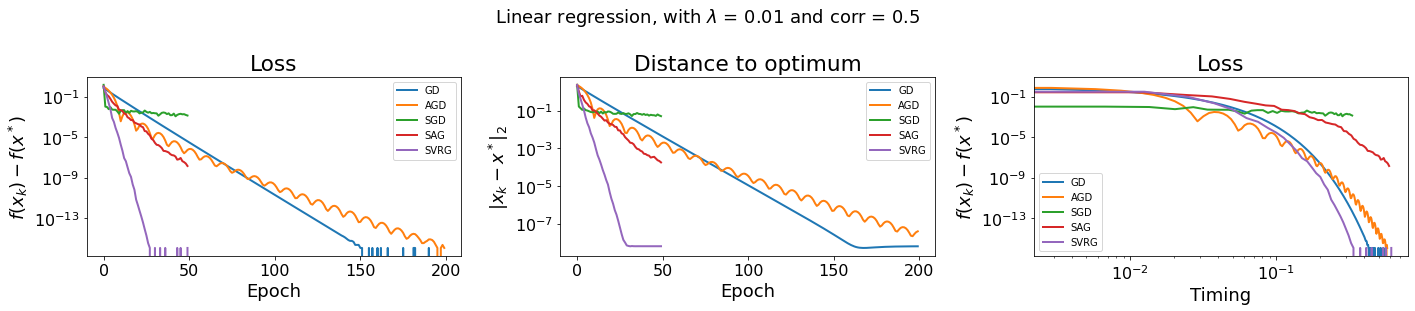

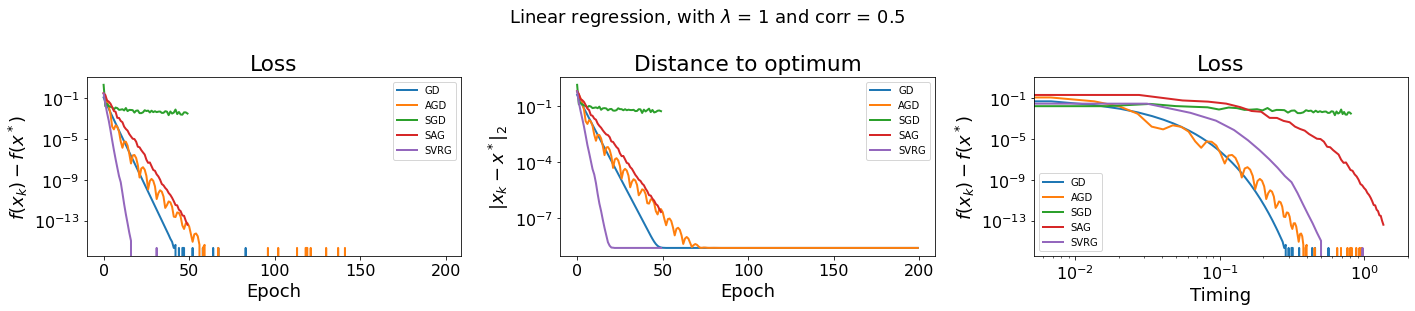

In [208]:
lbda = 1/n**0.5
new_lbda = 1
compare_function_n( lbda = lbda, model= 'regression', corr=0.5)
compare_function_n( lbda = new_lbda, model= 'regression', corr=0.5)

*Comment :*

We observe that for linear regression the main difference when we choose a bigger $\lambda$ that the speed of convergence decreased namely for SVRG, SAG, AGD and GD, however SGD and SAG isn't much affected with the change of lambda, but SAG get more accurate.

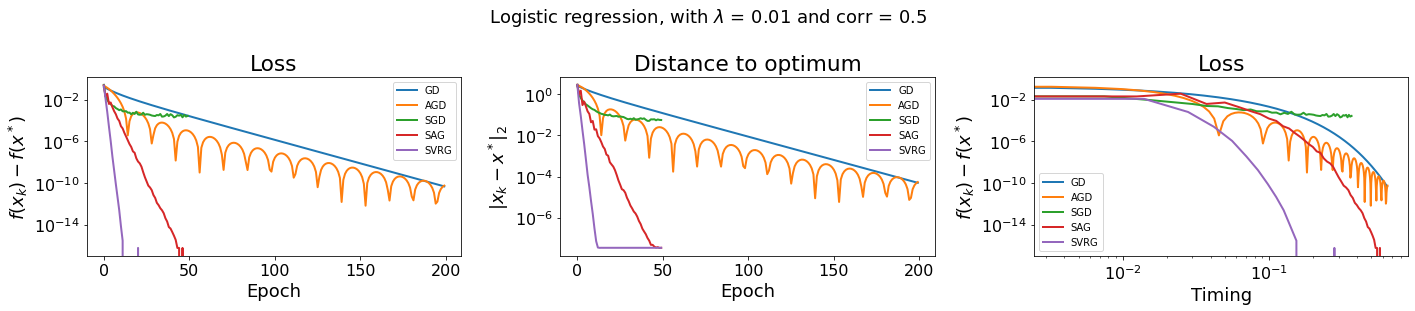

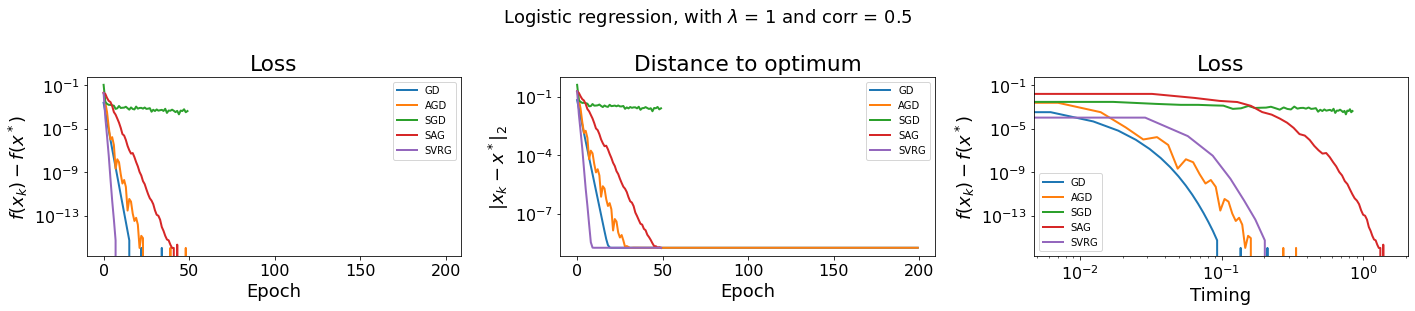

In [209]:
lbda = 1/n**0.5
new_lbda = 1
compare_function_n( lbda = lbda, model= 'logistic', corr=0.5)
compare_function_n( lbda = new_lbda, model= 'logistic', corr=0.5)

*Comment :*

We observe that for logistic regression the main difference when we choose a bigger $\lambda$ that the speed of convergence increased namely for SVRG, SAG, AGD and GD, however SGD and SAG isn't much affected with the change of lambda as other methods. Also, the distance to optimum for deterministic methods decrease but for stochastic methods this distance increase slightly. Also determenistic methods outperform stochastic methods and GD got results better than any other method.

*Deductions :*

High ridge regularization is generally better than the lower and $1/\sqrt n$ one in Linear Regression. It gives slightly quicker descents for the majority of solvers only SAG which is not much affeced by $\lambda$. Also, when we have high penalization term the variance is too high.

High ridge regularization, on the other hand, performs way better than the low ridge and $1/\sqrt n$ one for Logistic Regression, especially for SVRG and AGD methods, they both converge. We can verify that the descent is way quicker as well as the timing. However, the stochastic methods are slightly less stable using high regularization. SGD isn't much affected in term of time covergence but is more stable and smooth when penalization term is low.

***QUESTIONS :***
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

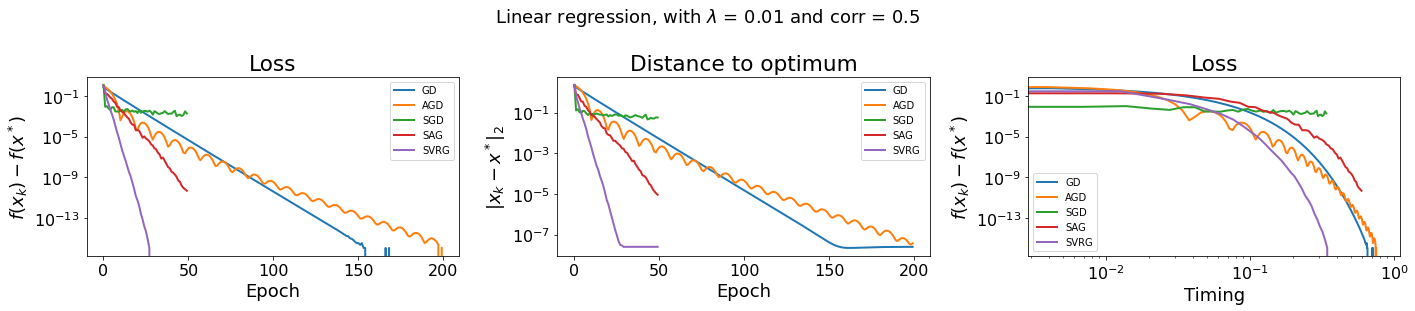

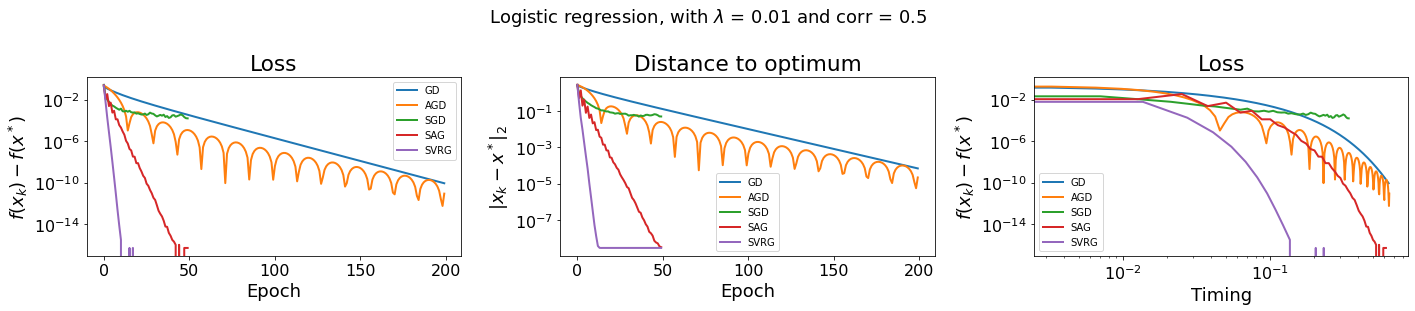

In [210]:
compare_function_n( lbda = lbda, model= 'regression', corr= 0.5)
compare_function_n( lbda = lbda, model= 'logistic', corr= 0.5)

Case of high correlation ($corr=0.9$):

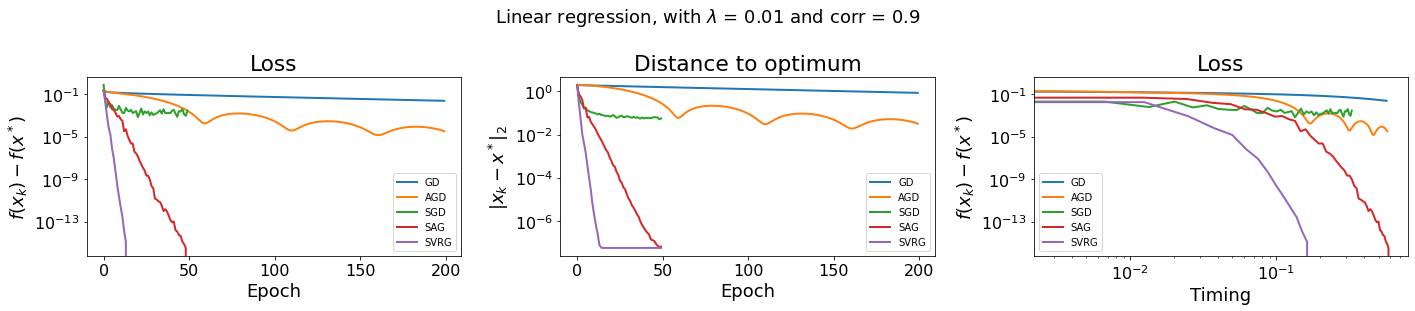

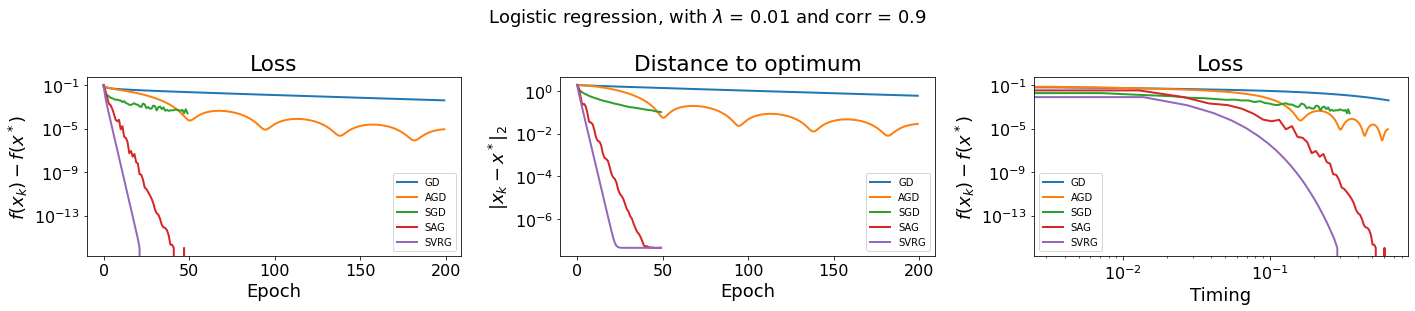

In [211]:
lbda = 1/n**(0.5)
corr = 0.9
compare_function_n( lbda = lbda, model= 'regression', corr= corr)
compare_function_n( lbda = lbda, model= 'logistic', corr= corr)

*Comment :* 

Here we see clearly the linear convergence of SVRG and 

Case of low correlation ($corr=0.1$):

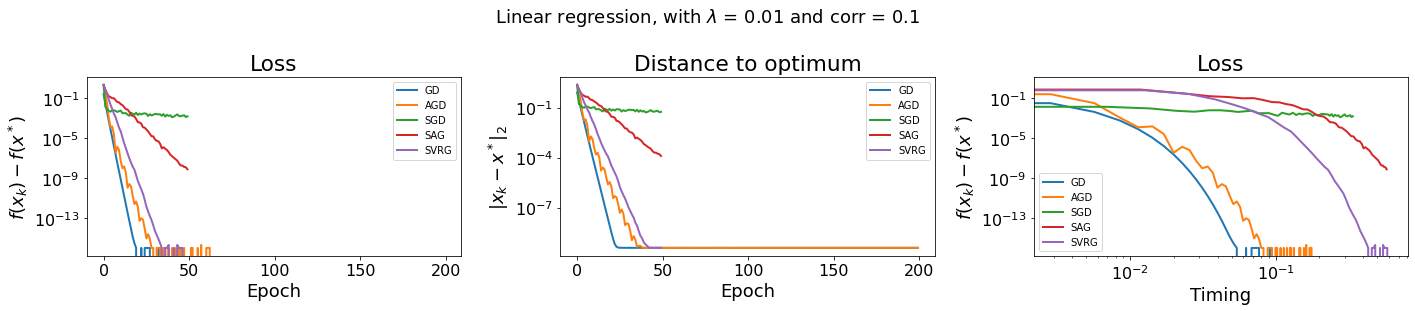

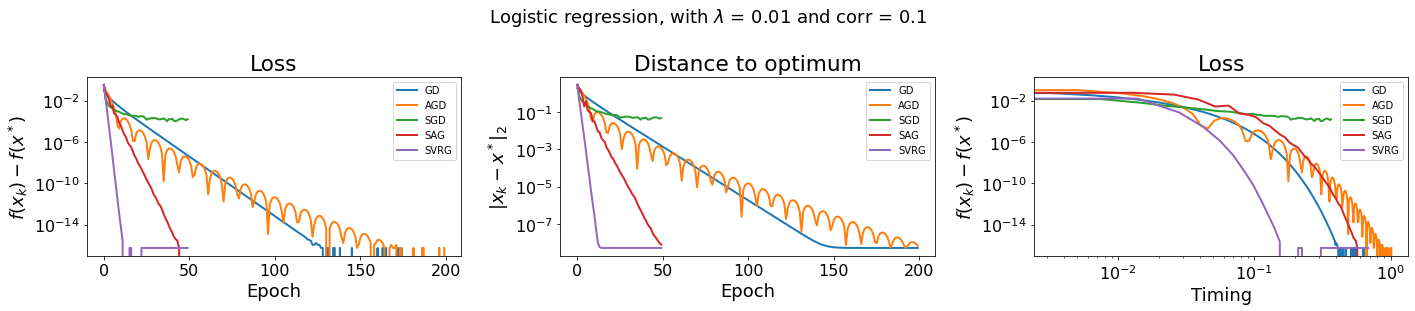

In [213]:
lbda = 1/n**(0.5)
corr = 0.1
compare_function_n( lbda = lbda, model= 'regression', corr= corr)
compare_function_n( lbda = lbda, model= 'logistic', corr= corr)

We can observe rom the GD and AGD (**deterministic approaches**), that they are strongly affected by the level of correlation, giving very good results for uncorrelated data compared to stochastic methods, but much worse for correlated data. On another hand, AGD is even slower than GD for uncorrelated data in the case of Ridge linear regression. AGD becomes really unstable with uncorrelated data.

**Stochastic methods**, in general, perform worse for uncorrelated data than for correlated data in terms of convergence speed and accuracy. Otherwise the SVRG, it performs well. The SGD method appears to be robust to variation in correlation.

Also, the SAG is less affected by change of correlation, it tends to have the same behaviour of stochastic solvers with less change in term of convergence speed and distance to optimum.

We often observe a high variance of our methods when they achieve a loss or a distance to optimum of $10^{-15}$, this variance is due to a numerical constraint that the resulotion is up this value as we can discover using the following formula : `np.finfo(np.float64)`

In [214]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

***QUESTIONS :***
- Conclude

***Conclusion***

Variance reduced methods use only one stochastic gradient per
iteration and converge linearly on strongly convex functions :

    ● SAG only needs to know the smoothness parameter to work, but requires storing n past stochastic gradients

    ● SVRG only has O(d) storage, but requires full gradient computations every so often. Has an extra “number of inner iterations” parameter to tune

**Deterministic methods** have in general less parameters and are more stable due to the fact that there's no term B that doesn't converge in the upper bound of our approximationas in stochastic methods as follow : $\mathop{\mathbb{E}}[|w_t - w_*|_{2}^2] \le (1-\alpha\mu)^t|w^0-w^*|_{2}^2 + (\alpha/\mu) B^2 $. So they are more intersting in the case of small dataset were the computational power isn't a limitation.

However, **stochastic algorithms** use only a subset of the data set, so they require less memory stored at any given time. For this reason, they are generally more sensitive to the size of data and work better and faster for large data sets compared to other methods.

Just for reflexion to improve the stochastic methods, we could be tune them by changing the random selection because the way we sample randomly an uniforme index, the computer find hard to do this task and take more time, this phenomena is known by "Cash misses". We can shuffle the data and select to avoid the jumps in memory.

At the end of the day, the results may change from case to case and the best model will be chosen based on the problem and the situation we are facing.

Thank you for your time!